In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# 简单的训练循环
# 使用REINFORCE算法：对每个智能体独立地基于蒙特卡洛方法更新策略。
# 假设各智能体共享经验（集中训练），但决策分散执行——即每个智能体在执行时只访问自己的网络和观测。

def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=5160):
    # 根据env初始化
    obs = env.reset()
    agents = env.agents
    
    # 为每个agent建立独立的策略网络和优化器
    policies = {}
    optimizers = {}
    for agent in agents:
        obs_dim = env.observation_space(agent).shape[0]
        act_space = env.action_space(agent).n
        policy = PolicyNetwork(obs_dim, act_space)
        policies[agent] = policy
        optimizers[agent] = optim.Adam(policy.parameters(), lr=lr)
    
    # 记录所有回合的总奖励
    total_rewards_history = []
    
    # 开始训练
    for episode in tqdm(range(num_episodes)):
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False
        
        # 存储本回合数据
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}
        actions_history = []  # 记录每个时间步所有智能体的动作
        
        while not done_flag:
            actions = {}
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                with torch.no_grad():
                    logits = policies[agent](obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            # 记录当前时间步的动作
            actions_history.append([actions[agent] for agent in agents])
            
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # 计算每个agent的回报，并更新策略
        for agent in agents:
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
            action_batch = torch.LongTensor(trajectories[agent]["actions"])
            return_batch = torch.FloatTensor(returns)
            
            optimizers[agent].zero_grad()
            logits = policies[agent](obs_batch)
            log_probs = torch.log_softmax(logits, dim=-1)
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            
            loss = -(chosen_log_probs * return_batch).mean()
            loss.backward()
            optimizers[agent].step()
        
        # 记录总奖励
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)
        
        # 检查是否达到了目标奖励
        if total_reward_this_episode >= reward_threshold:
            for step in actions_history:
                print(step)  # 按行输出动作选择矩阵
            print("=======!!!!!!!!!!!!!!!=======")

    return total_rewards_history, policies

from env_new.MAenv_2 import CustomMAEnvironment2
# 创建环境     
if __name__ == "__main__":      
    # 创建环境
    env = CustomMAEnvironment2(num_agents=5, num_iterations=200, dt=0.1)
    # 开始训练
    rewards_history, policies = train_multiagent(env, num_episodes=60000, gamma=0.99, lr=0.001)
    
    np.save("rewards_history1.npy", rewards_history)
    print("Rewards history saved")

    # 绘制总体回报的变化曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Agent agent_0: Observation space shape = (3,)
Agent agent_1: Observation space shape = (3,)
Agent agent_2: Observation space shape = (4,)
Agent agent_3: Observation space shape = (3,)
Agent agent_4: Observation space shape = (2,)
['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4']


  0%|          | 0/60000 [00:00<?, ?it/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_5845/652770185.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
  0%|          | 26/60000 [00:01<43:46, 22.83it/s] 


KeyboardInterrupt: 

Rewards history loaded successfully.
Top 1: Reward = 5218.314818976563, Step = 113834
Top 2: Reward = 5217.951930986819, Step = 105162
Top 3: Reward = 5199.0952591732075, Step = 89675
Top 4: Reward = 5186.683195332746, Step = 113097
Top 5: Reward = 5184.305611700276, Step = 143233
Top 6: Reward = 5169.581741900453, Step = 85525
Top 7: Reward = 5169.263654408466, Step = 81523
Top 8: Reward = 5163.522726932492, Step = 51791
Top 9: Reward = 5156.939406761357, Step = 123660
Top 10: Reward = 5153.597993251459, Step = 51922


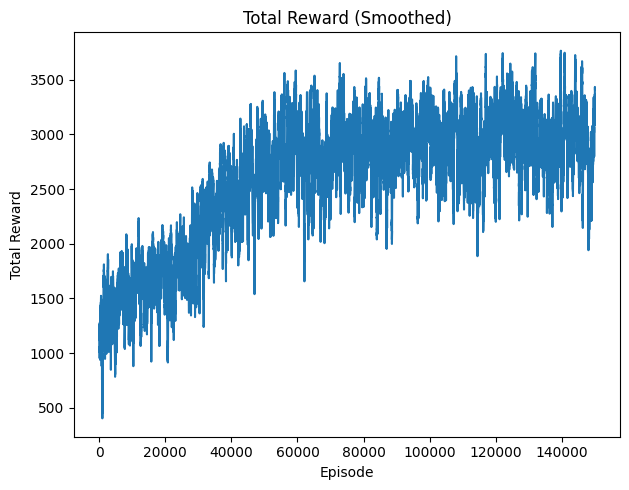

In [10]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.99):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()


-----------

Training: 100%|██████████| 100/100 [00:04<00:00, 23.83episode/s, Avg Reward (last 10 episodes)=-61.4]

Rewards history saved
Saved policy for agent_0 to agent_0_policy.pth
Saved policy for agent_1 to agent_1_policy.pth
Saved policy for agent_2 to agent_2_policy.pth
Saved policy for agent_3 to agent_3_policy.pth
Saved policy for agent_4 to agent_4_policy.pth


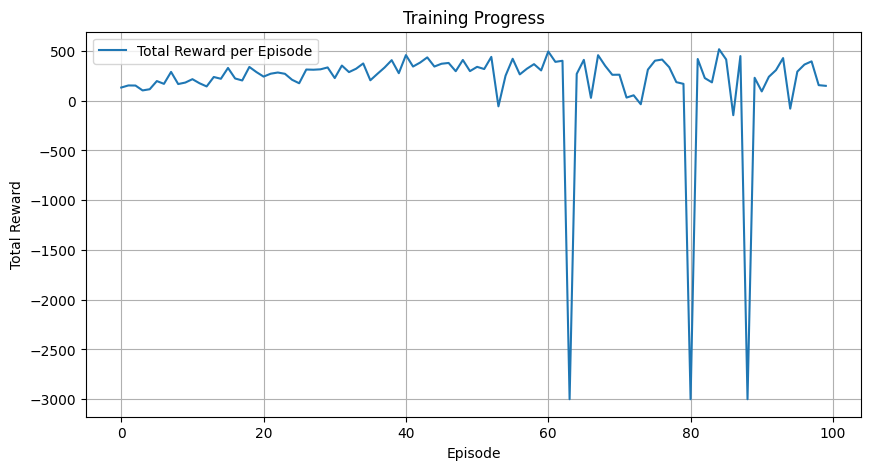

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# 简单的训练循环
# 使用REINFORCE算法：对每个智能体独立地基于蒙特卡洛方法更新策略。
# 假设各智能体共享经验（集中训练），但决策分散执行——即每个智能体在执行时只访问自己的网络和观测。


def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=650):
    # 根据env初始化
    obs = env.reset()
    agents = env.agents
    
    # 为每个agent建立独立的策略网络和优化器
    policies = {}
    optimizers = {}
    for agent in agents:
        obs_dim = env.observation_space(agent).shape[0]
        act_space = env.action_space(agent).n
        policy = PolicyNetwork(obs_dim, act_space)
        policies[agent] = policy
        optimizers[agent] = optim.Adam(policy.parameters(), lr=lr)
    
    # 记录所有回合的总奖励
    total_rewards_history = []
    
    # 开始训练
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")
    for episode in progress_bar:
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False
        
        # 存储本回合数据
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}
        actions_history = []  # 记录每个时间步所有智能体的动作
        
        while not done_flag:
            actions = {}
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                with torch.no_grad():
                    logits = policies[agent](obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            # 记录当前时间步的动作
            actions_history.append([actions[agent] for agent in agents])
            
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # 计算每个agent的回报，并更新策略
        for agent in agents:
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
            action_batch = torch.LongTensor(trajectories[agent]["actions"])
            return_batch = torch.FloatTensor(returns)
            
            optimizers[agent].zero_grad()
            logits = policies[agent](obs_batch)
            log_probs = torch.log_softmax(logits, dim=-1)
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            
            loss = -(chosen_log_probs * return_batch).mean()
            loss.backward()
            optimizers[agent].step()
        
        # 记录总奖励
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)
        
        # 每隔10步更新tqdm显示
        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})
        
        # 检查是否达到了目标奖励
        if total_reward_this_episode >= reward_threshold:
            for step in actions_history:
                print(step)  # 按行输出动作选择矩阵
            print("=======!!!!!!!!!!!!!!!=======")

    return total_rewards_history, policies

from env_new.MAenv_3 import CustomMAEnvironment3
# 创建环境     
if __name__ == "__main__":      
    # 创建环境
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)
    # 开始训练
    rewards_history, policies = train_multiagent(env, num_episodes=100, gamma=0.99, lr=0.001)
    
    np.save("rewards_history_onlydone.npy", rewards_history)
    print("Rewards history saved")
    
    # 保存每个智能体的策略
    for agent, policy in policies.items():
        torch.save(policy.state_dict(), f"{agent}_policy.pth")
        print(f"Saved policy for {agent} to {agent}_policy.pth")

    # 绘制总体回报的变化曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

Rewards history loaded successfully.
Top 1: Reward = 677, Step = 7060
Top 2: Reward = 676, Step = 44312
Top 3: Reward = 666, Step = 19005
Top 4: Reward = 660, Step = 29182
Top 5: Reward = 658, Step = 44571
Top 6: Reward = 651, Step = 21612
Top 7: Reward = 647, Step = 40620
Top 8: Reward = 637, Step = 22162
Top 9: Reward = 634, Step = 48641
Top 10: Reward = 634, Step = 21619


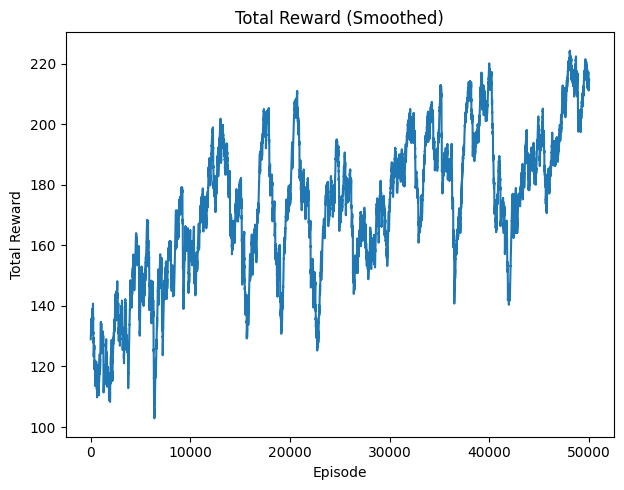

In [6]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history_onlydone.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.999):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()
